# basic nonlinear transformations in TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import math

sess = tf.InteractiveSession()

In [2]:
# some simple constants
x1 = tf.Variable(tf.truncated_normal([5], mean=3, stddev=1./math.sqrt(5)))
x2 = tf.Variable(tf.truncated_normal([5], mean=-1, stddev=1./math.sqrt(5)))
x3 = tf.Variable(tf.truncated_normal([5], mean=0, stddev=1./math.sqrt(5)))

In [3]:
sess.run(tf.initialize_all_variables())

In [4]:
# squaring makes large values extreme (and positive)
sqx2 = x2 * x2
print(x2.eval())
print(sqx2.eval())

[-0.34221762 -1.02533031 -0.80327761 -1.08198428 -1.86417794]
[ 0.1171129   1.05130219  0.64525491  1.17068994  3.47515941]


In [5]:
# logarithm makes small values more pronounced (and negative)
# large values get more squished together; smaller values more spread out
logx1 = tf.log(x1)
print(x1.eval())
print(logx1.eval())

[ 2.72943306  2.37264395  3.0030129   2.92378759  2.77168322]
[ 1.00409389  0.86400491  1.09961605  1.07287991  1.01945484]


In [6]:
# sigmoid -- extreme values get flattened to +1 or 0; inputs close to zero stay similar
sigx3 = tf.sigmoid(x3)
print(x3.eval())
print(sigx3.eval())

[ 0.20502356 -0.60329938 -0.32452604 -0.81719279 -0.21540968]
[ 0.55107707  0.35358921  0.41957313  0.30635989  0.4463549 ]


In [7]:
# we linearly combine multiple inputs, then transform
w1 = tf.constant(0.1)
w2 = tf.constant(0.2)
sess.run(tf.initialize_all_variables())
n1 = tf.sigmoid(w1*x1 + w2*x2)
print((w1*x1).eval())
print((w2*x2).eval())
print(n1.eval())

[ 0.30974466  0.29231226  0.32192189  0.28840032  0.37720141]
[-0.05850004 -0.23019338 -0.20194454 -0.28667626 -0.22765937]
[ 0.56248283  0.51552474  0.52995843  0.500431    0.53731602]


In [8]:
sess.close()

# adapting linear regression code for one hidden layer model

In [9]:
from tqdm import tqdm

In [10]:
np.random.seed(0)

In [11]:
data = np.load('data/data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

In [12]:
import matplotlib.pyplot as plt
plt.ion()

In [13]:
def to_onehot(labels, nclasses = 5):
    '''
    Convert labels to one-hot format
    '''
    outlabels = np.zeros((len(labels), nclasses))
    for i, l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

In [14]:
onehot = to_onehot(labels)

In [15]:
# split data into training and validation
indices = np.random.permutation(train.shape[0]) # shuffle indices
valid_cnt = int(train.shape[0] * 0.1) # use tenth of dataset for testing
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:] # break shuffled indices
test, train = train[test_idx,:], train[training_idx,:] # break data into train and test sets
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:] # break labels into train and test 

In [16]:
sess = tf.InteractiveSession()

In [17]:
# placeholders: tell TF we will supply value of this node by a feed_dict later
# input
x = tf.placeholder("float", [None, 1296])
# known labels
y_ = tf.placeholder("float", [None, 5])

In [18]:
# Hidden layer
num_hidden = 128 # how many nonlinear combinations will get passed to linear regression in the end
W1 = tf.Variable(tf.truncated_normal([1296, num_hidden], stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
h1 = tf.sigmoid(tf.matmul(x, W1) + b1)

# output layer
W2 = tf.Variable(tf.truncated_normal([num_hidden, 5], stddev=1./math.sqrt(5)))
b2 = tf.Variable(tf.constant(0.1, shape=[5]))

# initialize the variables
sess.run(tf.initialize_all_variables())

In [19]:
# define model
y = tf.matmul(h1, W2) + b2

In [20]:
# define error
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y + 1e-50, y_))

In [21]:
# now we train
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)

In [22]:
# define accuracy
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [23]:
# actually train
epochs = 5000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs)):
    # record summary data, and the accuracy
    if i % 10 == 0:
        # check accuracy on train set
        A = accuracy.eval(feed_dict={
                x: train.reshape([-1, 1296]),
                y_: onehot_train})
        train_acc[i//10] = A
        # and now the validation set
        A = accuracy.eval(feed_dict={
                x: test.reshape([-1, 1296]),
                y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={
            x: train.reshape([-1, 1296]),
            y_: onehot_train
        })

100%|██████████| 5000/5000 [04:02<00:00, 20.59it/s]


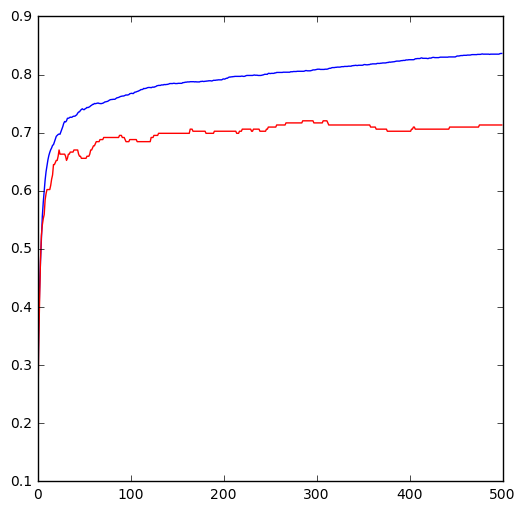

In [24]:
# plot the accuracy curves; note that the accuracy flattens out ...
plt.figure(figsize=(6,6))
plt.plot(train_acc,'b')
plt.plot(test_acc,'r')

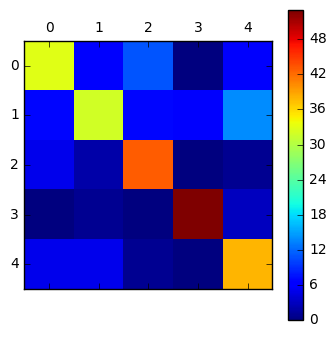

In [25]:
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1, 1296]),
                                  y_: onehot_test}), axis = 1)
conf = np.zeros([5, 5])
for p,t in zip(pred, np.argmax(onehot_test, axis = 1)):
    conf[t, p] += 1

plt.matshow(conf)
plt.colorbar()

Confusion matrix, without normalization
[[33  6 11  0  6]
 [ 7 32  7  6 14]
 [ 5  2 43  0  1]
 [ 0  1  0 53  3]
 [ 5  5  1  0 38]]
Normalized confusion matrix
[[ 0.59  0.11  0.2   0.    0.11]
 [ 0.11  0.48  0.11  0.09  0.21]
 [ 0.1   0.04  0.84  0.    0.02]
 [ 0.    0.02  0.    0.93  0.05]
 [ 0.1   0.1   0.02  0.    0.78]]


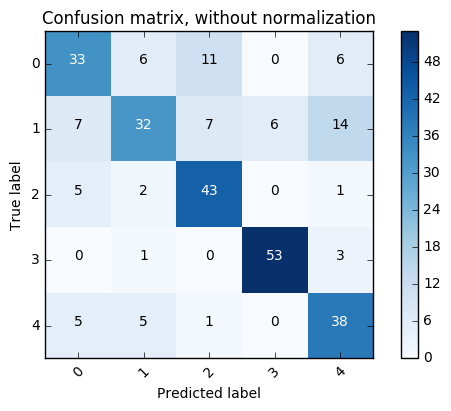

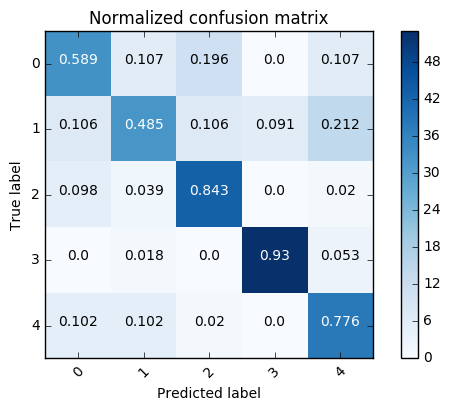

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_predictions = tf.argmax(y, 1).eval(feed_dict={
                x: test.reshape([-1, 1296]),
                y_: onehot_test})

y_true = tf.argmax(y_, 1).eval(feed_dict={y_: onehot_test})

cnf_matrix = confusion_matrix(y_true, y_predictions)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

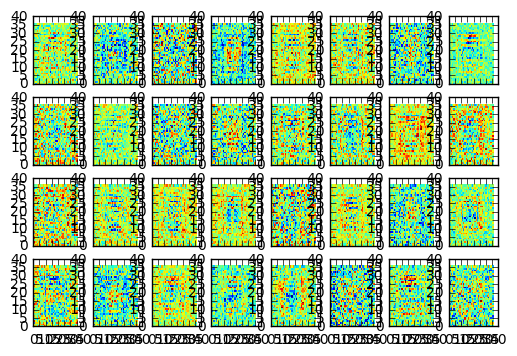

In [27]:
# let's look at a subplot of some weights
plt.figure(figsize=(10,10))
f, plts = plt.subplots(4, 8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))

In [28]:
sess.close()